# 03 — Feature Engineering

This notebook extracts hand-crafted features from the windowed time-series data:
1. **Statistical features**: mean, std, min, max, skewness, kurtosis
2. **Frequency-domain features**: FFT-based (dominant frequency, spectral energy)
3. **Feature selection**: SelectKBest with mutual information
4. Save feature-engineered dataset

These features flatten each (128, 30) window into a fixed-length vector for
classical ML algorithms.

---

## 3.1 — Imports and Load Processed Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from scipy import stats
from scipy.fft import fft, fftfreq
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)

# Load preprocessed data
DATA_DIR = Path('processed_data')

X_train = np.load(DATA_DIR / 'X_train.npy')   # (n_train, 128, 30)
X_test  = np.load(DATA_DIR / 'X_test.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
y_test  = np.load(DATA_DIR / 'y_test.npy')

with open(DATA_DIR / 'metadata.json') as f:
    meta = json.load(f)

sensor_cols = meta['sensor_columns']
ACTIVITY_MAP = {int(k): v for k, v in meta['activity_map'].items()}

print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')
print(f'Features: {len(sensor_cols)} sensor channels')

X_train: (81935, 128, 30)  |  X_test: (28570, 128, 30)
Features: 30 sensor channels


## 3.2 — Statistical Features

For each window and each sensor channel, we compute:
- **Mean** — average value over the window
- **Std** — standard deviation (variability)
- **Min / Max** — extremes
- **Skewness** — asymmetry of distribution
- **Kurtosis** — tailedness
- **Median** — robust central tendency
- **IQR** — interquartile range (robust spread)
- **RMS** — root mean square (signal energy)

This yields 8 × 30 = 240 statistical features per window.

In [2]:
def extract_statistical_features(X_windows, sensor_names):
    """
    Extract statistical features from windowed data.
    X_windows: shape (n_windows, window_size, n_features)
    Returns: DataFrame with named feature columns.
    """
    n_windows = X_windows.shape[0]
    features = {}
    
    for i, col in enumerate(sensor_names):
        channel = X_windows[:, :, i]
        
        features[f'{col}_mean']     = np.mean(channel, axis=1)
        features[f'{col}_std']      = np.std(channel, axis=1)
        features[f'{col}_min']      = np.min(channel, axis=1)
        features[f'{col}_max']      = np.max(channel, axis=1)
        features[f'{col}_skew']     = stats.skew(channel, axis=1)
        features[f'{col}_kurtosis'] = stats.kurtosis(channel, axis=1)
        features[f'{col}_median']   = np.median(channel, axis=1)
        features[f'{col}_iqr']      = stats.iqr(channel, axis=1)
        features[f'{col}_rms']      = np.sqrt(np.mean(channel**2, axis=1))
    
    return pd.DataFrame(features)

print('Extracting statistical features...')
df_train_stat = extract_statistical_features(X_train, sensor_cols)
df_test_stat  = extract_statistical_features(X_test, sensor_cols)

print(f'✅ Statistical features: {df_train_stat.shape[1]} features per window')
print(f'   Train: {df_train_stat.shape}  |  Test: {df_test_stat.shape}')
df_train_stat.head()

Extracting statistical features...
✅ Statistical features: 270 features per window
   Train: (81935, 270)  |  Test: (28570, 270)


,q_w_chest_mean,q_w_chest_std,q_w_chest_min,q_w_chest_max,q_w_chest_skew,q_w_chest_kurtosis,q_w_chest_median,q_w_chest_iqr,q_w_chest_rms,q_x_chest_mean,...,g_y_right_hand_rms,g_z_right_hand_mean,g_z_right_hand_std,g_z_right_hand_min,g_z_right_hand_max,g_z_right_hand_skew,g_z_right_hand_kurtosis,g_z_right_hand_median,g_z_right_hand_iqr,g_z_right_hand_rms
0,1.254046,0.003290,1.250802,1.264055,0.926562,0.795368,1.255219,0.004418,1.254050,0.464034,...,0.012209,-0.002208,0.003184,-0.008490,0.010984,1.023957,2.986624,-0.002559,0.003389,0.003875
1,1.254115,0.002922,1.250802,1.259637,0.323970,-0.775510,1.255219,0.004418,1.254118,0.461248,...,0.011096,-0.003122,0.002299,-0.008490,0.001678,-0.199306,-0.360763,-0.002559,0.003389,0.003877
2,1.257670,0.004933,1.250802,1.268473,0.232998,-0.688697,1.259637,0.004418,1.257680,0.457108,...,0.006894,-0.002155,0.002078,-0.006795,0.001678,-0.186205,-0.498372,-0.001712,0.002542,0.002994
3,1.257428,0.005121,1.250802,1.268473,0.240770,-0.827968,1.259637,0.008836,1.257439,0.456583,...,0.016490,-0.007873,0.013143,-0.047451,0.006747,-1.769517,2.009916,-0.002559,0.009532,0.015321
4,1.248282,0.009318,1.224294,1.259637,-0.508900,-0.986220,1.250802,0.017672,1.248317,0.457896,...,0.032220,-0.020049,0.021498,-0.059313,0.041472,0.468354,-0.251929,-0.026707,0.035572,0.029396


## 3.3 — Frequency-Domain Features (FFT)

The Fast Fourier Transform reveals periodic patterns in sensor signals.
For each channel we extract:
- **Dominant frequency** — frequency with highest amplitude
- **Spectral energy** — total power in the spectrum
- **Spectral entropy** — spread of energy across frequencies
- **Mean frequency** — frequency centroid

This adds 4 × 30 = 120 frequency features.

In [3]:
def extract_fft_features(X_windows, sensor_names, sampling_rate=50):
    """
    Extract frequency-domain features from windowed data using FFT.
    """
    n_windows, window_size, n_features = X_windows.shape
    freqs = fftfreq(window_size, d=1.0/sampling_rate)[:window_size//2]
    features = {}
    
    for i, col in enumerate(sensor_names):
        channel = X_windows[:, :, i]
        
        # Compute FFT magnitude spectrum (positive frequencies only)
        fft_vals = np.abs(fft(channel, axis=1))[:, :window_size//2]
        
        # Dominant frequency
        dom_freq_idx = np.argmax(fft_vals[:, 1:], axis=1) + 1  # skip DC
        features[f'{col}_dom_freq'] = freqs[dom_freq_idx]
        
        # Spectral energy
        features[f'{col}_spec_energy'] = np.sum(fft_vals**2, axis=1)
        
        # Spectral entropy
        psd = fft_vals**2
        psd_norm = psd / (psd.sum(axis=1, keepdims=True) + 1e-12)
        features[f'{col}_spec_entropy'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-12), axis=1)
        
        # Mean frequency (spectral centroid)
        features[f'{col}_mean_freq'] = np.sum(freqs * fft_vals, axis=1) / (np.sum(fft_vals, axis=1) + 1e-12)
    
    return pd.DataFrame(features)

print('Extracting FFT features...')
df_train_fft = extract_fft_features(X_train, sensor_cols)
df_test_fft  = extract_fft_features(X_test, sensor_cols)

print(f'✅ FFT features: {df_train_fft.shape[1]} features per window')
df_train_fft.head()

Extracting FFT features...
✅ FFT features: 120 features per window


,q_w_chest_dom_freq,q_w_chest_spec_energy,q_w_chest_spec_entropy,q_w_chest_mean_freq,q_x_chest_dom_freq,q_x_chest_spec_energy,q_x_chest_spec_entropy,q_x_chest_mean_freq,q_y_chest_dom_freq,q_y_chest_spec_energy,...,g_x_right_hand_spec_entropy,g_x_right_hand_mean_freq,g_y_right_hand_dom_freq,g_y_right_hand_spec_energy,g_y_right_hand_spec_entropy,g_y_right_hand_mean_freq,g_z_right_hand_dom_freq,g_z_right_hand_spec_energy,g_z_right_hand_spec_entropy,g_z_right_hand_mean_freq
0,0.390625,25766.078125,0.000078,0.055650,0.390625,3527.945312,0.000121,0.088640,0.390625,3914.399414,...,3.282038,5.448301,10.156250,1.275661,4.444382,6.668957,0.390625,0.162939,2.961796,5.325662
1,1.562500,25768.896484,0.000062,0.045139,0.390625,3485.772705,0.000489,0.148176,1.562500,3909.992920,...,3.179237,5.549477,0.390625,1.139011,4.332738,6.990080,3.515625,0.202949,1.625754,5.426280
2,0.390625,25915.322266,0.000152,0.044413,0.390625,3423.429443,0.000172,0.089844,0.390625,3836.514404,...,4.542964,7.108191,10.546875,0.390951,4.456609,8.254792,3.515625,0.111464,2.240873,6.181336
3,0.390625,25905.386719,0.000162,0.043105,0.390625,3415.572998,0.000184,0.077520,0.390625,3844.774902,...,3.099760,4.297383,0.781250,2.233015,4.589955,6.319727,0.390625,2.430588,2.396430,4.422419
4,0.390625,25530.376953,0.000504,0.105835,0.781250,3435.444092,0.001219,0.177805,0.390625,4022.032959,...,2.511831,3.136843,0.781250,9.212870,3.931510,5.428112,0.390625,10.371956,1.799475,2.844881


In [4]:
# Combine all features
X_train_feat = pd.concat([df_train_stat, df_train_fft], axis=1)
X_test_feat  = pd.concat([df_test_stat, df_test_fft], axis=1)

print(f'Total engineered features: {X_train_feat.shape[1]}')
print(f'  Statistical: {df_train_stat.shape[1]}')
print(f'  FFT:         {df_train_fft.shape[1]}')
print(f'  Train shape: {X_train_feat.shape}')
print(f'  Test shape:  {X_test_feat.shape}')

Total engineered features: 390
  Statistical: 270
  FFT:         120
  Train shape: (81935, 390)
  Test shape:  (28570, 390)


## 3.4 — Feature Selection (SelectKBest with Mutual Information)

We rank features by their mutual information with the target label.
Mutual information captures both linear and non-linear dependencies,
making it more general than correlation-based methods.

In [5]:
# Handle any NaN/Inf from FFT computation
X_train_feat = X_train_feat.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_feat  = X_test_feat.replace([np.inf, -np.inf], np.nan).fillna(0)

# Compute mutual information scores
print('Computing mutual information scores (this may take a minute)...')
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X_train_feat, y_train)

mi_scores = pd.Series(mi_selector.scores_, index=X_train_feat.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(f'\nTop 20 features by mutual information:')
print(mi_scores.head(20).to_string())

Computing mutual information scores (this may take a minute)...

Top 20 features by mutual information:
a_x_left_knee_mean            0.925651
g_y_left_knee_spec_energy     0.916708
g_y_left_knee_rms             0.912195
g_y_left_knee_min             0.903196
g_y_left_knee_std             0.901921
g_y_left_knee_iqr             0.892208
a_z_left_knee_std             0.865778
a_z_left_knee_mean            0.863308
a_x_left_knee_min             0.859386
a_x_left_knee_median          0.849083
a_x_left_knee_std             0.848057
g_y_left_knee_max             0.842391
a_z_left_knee_iqr             0.817216
a_z_left_knee_median          0.806999
a_x_left_knee_iqr             0.788490
a_z_left_knee_min             0.788229
a_x_chest_iqr                 0.768265
a_x_left_knee_spec_entropy    0.763128
a_x_chest_std                 0.761842
g_x_left_knee_iqr             0.751988


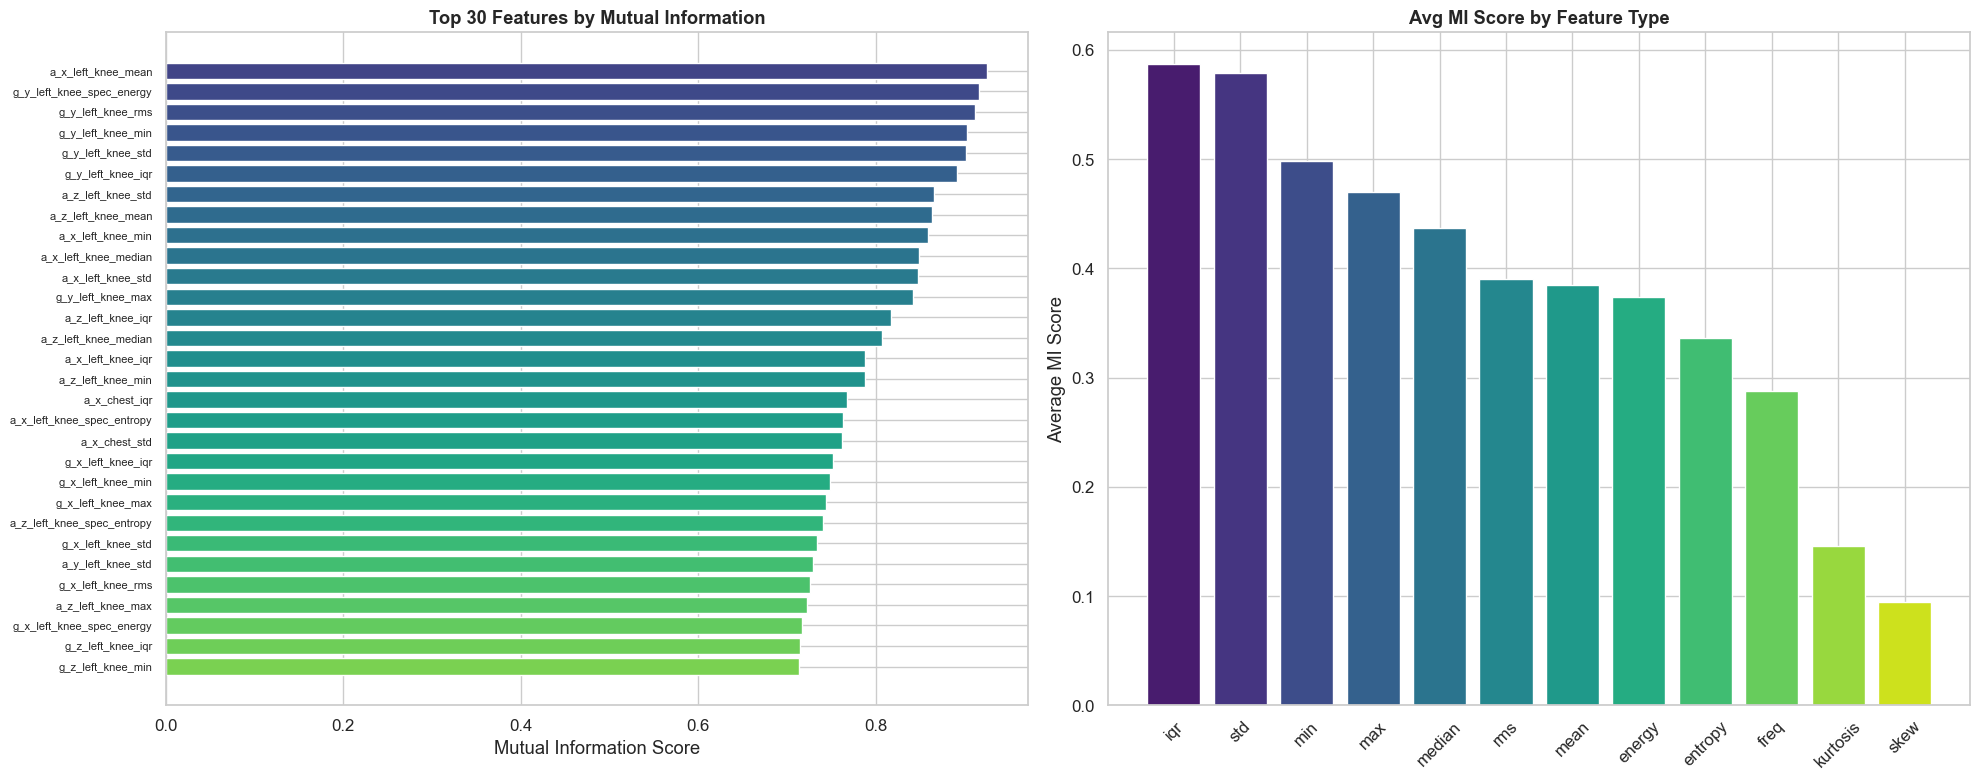

In [6]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Top 30 features
top_n = 30
top_features = mi_scores.head(top_n)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))

axes[0].barh(range(top_n), top_features.values[::-1], color=colors[::-1])
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features.index[::-1], fontsize=8)
axes[0].set_xlabel('Mutual Information Score')
axes[0].set_title(f'Top {top_n} Features by Mutual Information', fontweight='bold')

# Feature importance by category
cat_scores = {}
for feat_name, score in mi_scores.items():
    suffix = feat_name.split('_')[-1]
    if suffix not in cat_scores:
        cat_scores[suffix] = []
    cat_scores[suffix].append(score)

cat_avg = {k: np.mean(v) for k, v in cat_scores.items()}
cat_avg = dict(sorted(cat_avg.items(), key=lambda x: x[1], reverse=True))

axes[1].bar(cat_avg.keys(), cat_avg.values(), color=sns.color_palette('viridis', len(cat_avg)))
axes[1].set_title('Avg MI Score by Feature Type', fontweight='bold')
axes[1].set_ylabel('Average MI Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('feature_importance_mi.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Select top K features
K_BEST = 100

top_k_features = mi_scores.head(K_BEST).index.tolist()
X_train_selected = X_train_feat[top_k_features]
X_test_selected  = X_test_feat[top_k_features]

print(f'Selected top {K_BEST} features.')
print(f'  Train: {X_train_selected.shape}')
print(f'  Test:  {X_test_selected.shape}')

Selected top 100 features.
  Train: (81935, 100)
  Test:  (28570, 100)


## 3.5 — Save Engineered Features

In [8]:
output_dir = Path('processed_data')

# Save all features
X_train_feat.to_csv(output_dir / 'X_train_features_all.csv', index=False)
X_test_feat.to_csv(output_dir / 'X_test_features_all.csv', index=False)

# Save selected features
X_train_selected.to_csv(output_dir / 'X_train_features_selected.csv', index=False)
X_test_selected.to_csv(output_dir / 'X_test_features_selected.csv', index=False)

# Save feature names
with open(output_dir / 'selected_features.json', 'w') as f:
    json.dump({
        'all_features': list(X_train_feat.columns),
        'selected_features': top_k_features,
        'mi_scores': mi_scores.to_dict(),
        'k_best': K_BEST
    }, f, indent=2)

print(f'✅ Saved to {output_dir}/')
print(f'   All features:      {X_train_feat.shape[1]} columns')
print(f'   Selected features: {len(top_k_features)} columns')

✅ Saved to processed_data/
   All features:      390 columns
   Selected features: 100 columns


## 3.6 — Summary

| Feature Category | Count | Description |
|-----------------|-------|-------------|
| Statistical | 270 (9 × 30) | mean, std, min, max, skew, kurtosis, median, IQR, RMS |
| FFT | 120 (4 × 30) | dominant freq, spectral energy, spectral entropy, mean freq |
| **Total** | **390** | All engineered features |
| **Selected** | **100** | Top features by mutual information |

**Key observations:**
- Statistical features (especially std, RMS, IQR) tend to have the highest MI scores,
  indicating that variability measures are most discriminative for activity recognition.
- FFT features (spectral energy, dominant frequency) also rank highly, particularly
  for distinguishing walking/stairs from static activities.
- Accelerometer features generally score higher than quaternion features.

**Next:** Dimensionality reduction in `04_Dimensionality_Reduction.ipynb`.